# Calculate the high vs low years for temperature, ice fraction and nutrietns on a point by point basis using the POP grid... this will take longer, but could potenitally just look nicer?... High vs low years are slected using the 90th and 10th percentile. 
##  Units: 
    1. Temperature ($^o$ C)
    2. Ice Fraction (unitless)
    3. NO$_3$ concentration (mmol m$^{-3}$)

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

%matplotlib inline
from glob import glob
import dask
import pop_tools 
import statistics as stats
from statistics import mean

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## High vs low NO$_3$ 

In [4]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

In [8]:
variables = [f'{var}' for var in ['NO3']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [9]:
%%time
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_01_avg = xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    for month in months:
    
        ds_01 = xr.Dataset()

        file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-{month}.nc'))
        
        dsv_01=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
        for vv in variables: 
            ds_01 = xr.merge((ds_01, dsv_01[vv]))

            ds_01 = ds_01.drop([v for v in ds_01.variables if v not in keep_vars]).squeeze()
            ds_01_avg = xr.concat([ds_01_avg, ds_01],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 7min 51s, sys: 1min 3s, total: 8min 54s
Wall time: 11min 40s


In [10]:
%%time
NO3_ds_inter = np.empty([62,12,384,320])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    NO3_ds_inter[i,:,:,:] = ds_01_avg.NO3[x[i]:x[i]+12,0,:,:]

CPU times: user 43.2 s, sys: 6min 4s, total: 6min 47s
Wall time: 10min 56s


In [11]:
%%time
month = np.arange(0,12,1)
time = np.arange(0,62,1)
NO3_ds_inter_surface = xr.DataArray(NO3_ds_inter, coords={'time':time,'month':month, 'TLAT':ds_01_avg.TLAT, 'TLONG':ds_01_avg.TLONG},
                                    dims=['time','month', 'nlat', 'nlon'],
                                    attrs=dict(description="Surface NO3",units="ugC m^{-3}"))
NO3_ds_inter_surface = NO3_ds_inter_surface.to_dataset(name='NO3')

CPU times: user 519 µs, sys: 431 µs, total: 950 µs
Wall time: 955 µs


In [12]:
%%time
NO3_ds_inter_surface.to_netcdf('/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/NO3_ds_inter_surface.nc');

CPU times: user 16 ms, sys: 457 ms, total: 473 ms
Wall time: 611 ms


In [12]:
%%time
## Calculate climatology for each grid cell
no3_ao_clim = np.nanmean(NO3_ds_inter,axis=0) # Size (12,384,320)

CPU times: user 438 ms, sys: 161 ms, total: 599 ms
Wall time: 625 ms


In [13]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
no3_arctic_anom = np.empty([62,12,384,320]) ; no3_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        no3_arctic_anom[:,:,latitude,longitude] = NO3_ds_inter[:,:,latitude,longitude]-no3_ao_clim[:,latitude,longitude]

CPU times: user 2.41 s, sys: 161 ms, total: 2.57 s
Wall time: 2.65 s


In [16]:
%%time
no3_arctic_anom_yearly = np.nanmean(no3_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90_no3 = np.empty([384,320]) ; pcen_90_no3[:] = np.nan
pcen_10_no3 = np.empty([384,320]) ; pcen_10_no3[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 12 s, sys: 240 ms, total: 12.2 s
Wall time: 12.5 s


In [18]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_no3_years_arctic = {}
high_no3_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_no3_years_arctic = multi_dict(2, int)
high_no3_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] < pcen_10_no3[latitude,longitude])
        high_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] > pcen_90_no3[latitude,longitude])

In [19]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_temp = np.empty([12,384,320]) ; low_no3_years_temp[:] = np.nan
high_no3_years_temp = np.empty([12,384,320]) ; high_no3_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds_inter[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds_inter[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

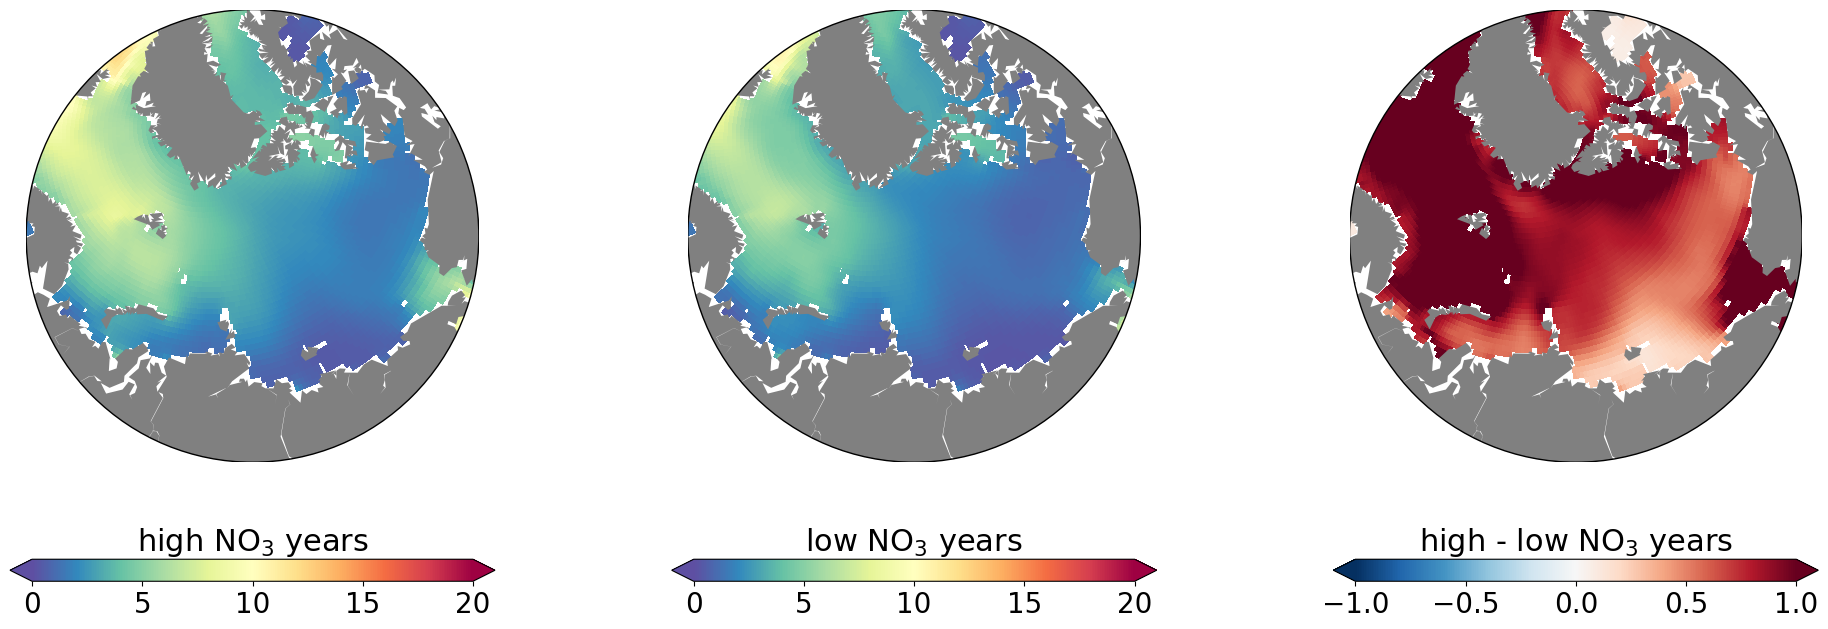

In [25]:
fig = plt.figure(figsize=(20, 20))

# High NO3 
ax = fig.add_subplot(3, 3, 1)
lon, lat, high_no3 = adjust_pop_grid(ds_01_avg.TLONG, ds_01_avg.TLAT, np.nanmean(high_no3_years_temp,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, high_no3, cmap='Spectral_r', vmin = 0, vmax = 20);
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

# Low NO3 
ax = fig.add_subplot(3, 3, 2)
lon, lat, low_no3 = adjust_pop_grid(ds_01_avg.TLONG, ds_01_avg.TLAT, np.nanmean(low_no3_years_temp,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, low_no3, cmap='Spectral_r', vmin = 0, vmax = 20);
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('low NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

# High - Low NO3  
ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, high_no3-low_no3, cmap='RdBu_r', vmin = -1, vmax = 1);
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high - low NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)
plt.tight_layout()

## High vs Low Temperature 

In [13]:
variables = [f'{var}' for var in ['TEMP']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [14]:
%%time
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_01_avg = xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    for month in months:
    
        ds_01 = xr.Dataset()

        file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-{month}.nc'))
        
        dsv_01=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
        for vv in variables: 
            ds_01 = xr.merge((ds_01, dsv_01[vv]))

            ds_01 = ds_01.drop([v for v in ds_01.variables if v not in keep_vars]).squeeze()
            ds_01_avg = xr.concat([ds_01_avg, ds_01],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 7min 51s, sys: 1min 3s, total: 8min 55s
Wall time: 10min 30s


In [15]:
%%time
temp_ds_inter = np.empty([62,12,384,320])
temp_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    temp_ds_inter[i,:,:,:] = ds_01_avg.TEMP[x[i]:x[i]+12,0,:,:]

CPU times: user 42.3 s, sys: 6min, total: 6min 43s
Wall time: 10min 37s


In [16]:
%%time
month = np.arange(0,12,1)
time = np.arange(0,62,1)
temp_ds_inter_surface = xr.DataArray(temp_ds_inter, coords={'time':time,'month':month, 'TLAT':ds_01_avg.TLAT, 'TLONG':ds_01_avg.TLONG},
                                    dims=['time','month', 'nlat', 'nlon'],
                                    attrs=dict(description="Surface temperature",units="oC"))
temp_ds_inter_surface = temp_ds_inter_surface.to_dataset(name='TEMP')

CPU times: user 669 µs, sys: 554 µs, total: 1.22 ms
Wall time: 3.51 ms


In [17]:
%%time
temp_ds_inter_surface.to_netcdf('/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/temp_ds_inter_surface.nc');

CPU times: user 17 ms, sys: 462 ms, total: 479 ms
Wall time: 776 ms


In [31]:
## Calculate climatology for each grid cell
temp_ao_clim = np.nanmean(temp_ds_inter,axis=0) # Size (384,320)

In [32]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
temp_arctic_anom = np.empty([62,12,384,320]) ; temp_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        temp_arctic_anom[:,:,latitude,longitude] = temp_ds_inter[:,:,latitude,longitude]-temp_ao_clim[:,latitude,longitude]

CPU times: user 2.39 s, sys: 104 ms, total: 2.49 s
Wall time: 2.6 s


In [34]:
%%time
temp_arctic_anom_yearly = np.nanmean(temp_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90 = np.empty([384,320]) ; pcen_90[:] = np.nan
pcen_10 = np.empty([384,320]) ; pcen_10[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 11.4 s, sys: 290 ms, total: 11.7 s
Wall time: 12 s


In [35]:
%%time
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_temp_years_arctic = {}
high_temp_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_temp_years_arctic = multi_dict(2, int)
high_temp_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] < pcen_10[latitude,longitude])
        high_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] > pcen_90[latitude,longitude])

CPU times: user 768 ms, sys: 32.2 ms, total: 800 ms
Wall time: 828 ms


In [36]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
cold_years_temp = np.empty([12,384,320]) ; cold_years_temp[:] = np.nan
warm_years_temp = np.empty([12,384,320]) ; warm_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        cold_years_temp[:,latitude,longitude] = np.nanmean(temp_ds_inter[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        warm_years_temp[:,latitude,longitude] = np.nanmean(temp_ds_inter[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

CPU times: user 8.19 s, sys: 21.3 ms, total: 8.21 s
Wall time: 8.44 s


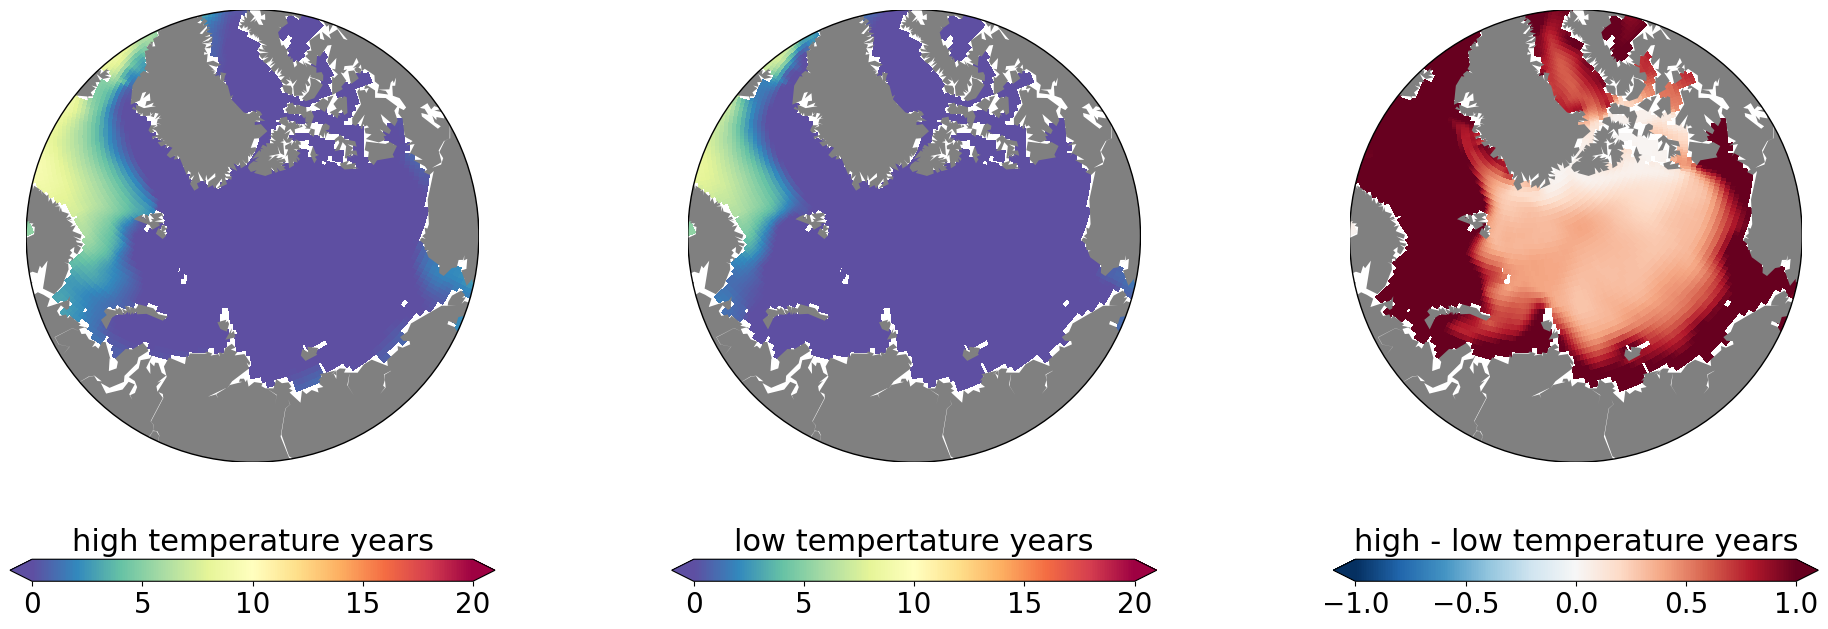

In [37]:
fig = plt.figure(figsize=(20, 20))

# High NO3 
ax = fig.add_subplot(3, 3, 1)
lon, lat, high = adjust_pop_grid(ds_01_avg.TLONG, ds_01_avg.TLAT, np.nanmean(warm_years_temp,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, high, cmap='Spectral_r', vmin = 0, vmax = 20);
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high temperature years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

# Low NO3 
ax = fig.add_subplot(3, 3, 2)
lon, lat, low = adjust_pop_grid(ds_01_avg.TLONG, ds_01_avg.TLAT, np.nanmean(cold_years_temp,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, low, cmap='Spectral_r', vmin = 0, vmax = 20);
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('low tempertature years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

# High - Low NO3  
ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, high-low, cmap='RdBu_r', vmin = -1, vmax = 1);
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high - low temperature years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)
plt.tight_layout()

## High vs Low ICE Fraction Years

In [5]:
variables = [f'{var}' for var in ['ECOSYS_IFRAC']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [6]:
%%time
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_01_avg = xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    for month in months:
    
        ds_01 = xr.Dataset()

        file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-{month}.nc'))
        
        dsv_01=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
        for vv in variables: 
            ds_01 = xr.merge((ds_01, dsv_01[vv]))

            ds_01 = ds_01.drop([v for v in ds_01.variables if v not in keep_vars]).squeeze()
            ds_01_avg = xr.concat([ds_01_avg, ds_01],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 7min 52s, sys: 1min 3s, total: 8min 55s
Wall time: 10min 54s


In [7]:
%%time
ECOSYS_IFRAC_ds_inter = np.empty([62,12,384,320])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds_01_avg.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

CPU times: user 24.5 s, sys: 17.2 s, total: 41.7 s
Wall time: 2min 39s


In [8]:
%%time
month = np.arange(0,12,1)
time = np.arange(0,62,1)
ECOSYS_IFRAC_ds_inter_surface = xr.DataArray(ECOSYS_IFRAC_ds_inter, coords={'time':time,'month':month, 'TLAT':ds_01_avg.TLAT, 'TLONG':ds_01_avg.TLONG},
                                    dims=['time','month', 'nlat', 'nlon'],
                                    attrs=dict(description="Ecosystem Ice Fraction",units=""))
ECOSYS_IFRAC_ds_inter_surface = ECOSYS_IFRAC_ds_inter_surface.to_dataset(name='ECOSYS_IFRAC')

CPU times: user 705 µs, sys: 0 ns, total: 705 µs
Wall time: 710 µs


In [9]:
%%time
ECOSYS_IFRAC_ds_inter_surface.to_netcdf('/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/ECOSYS_IFRAC_ds_inter_surface.nc');

CPU times: user 20.3 ms, sys: 465 ms, total: 485 ms
Wall time: 606 ms


In [11]:
## Calculate climatology for each grid cell
ice_ao_clim = np.nanmean(ECOSYS_IFRAC_ds_inter,axis=0) # Size (12,384,320)

In [12]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
ice_arctic_anom = np.empty([62,12,384,320]) ; ice_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        ice_arctic_anom[:,:,latitude,longitude] = ECOSYS_IFRAC_ds_inter[:,:,latitude,longitude]-ice_ao_clim[:,latitude,longitude]

CPU times: user 2.4 s, sys: 144 ms, total: 2.54 s
Wall time: 2.59 s


In [13]:
ice_arctic_anom_yearly = np.nanmean(ice_arctic_anom,axis=1) # size is now (62,180,360)

# Create empty arrays filled with NaN's 
pcen_90_ice = np.empty([384,320]) ; pcen_90_ice[:] = np.nan
pcen_10_ice = np.empty([384,320]) ; pcen_10_ice[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

In [14]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_ice_years_arctic = {}
high_ice_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_ice_years_arctic = multi_dict(2, int)
high_ice_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] < pcen_10_ice[latitude,longitude])
        high_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] > pcen_90_ice[latitude,longitude])

In [15]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_ice_years_temp = np.empty([12,384,320]) ; low_ice_years_temp[:] = np.nan
high_ice_years_temp = np.empty([12,384,320]) ; high_ice_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds_inter[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds_inter[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1)) 

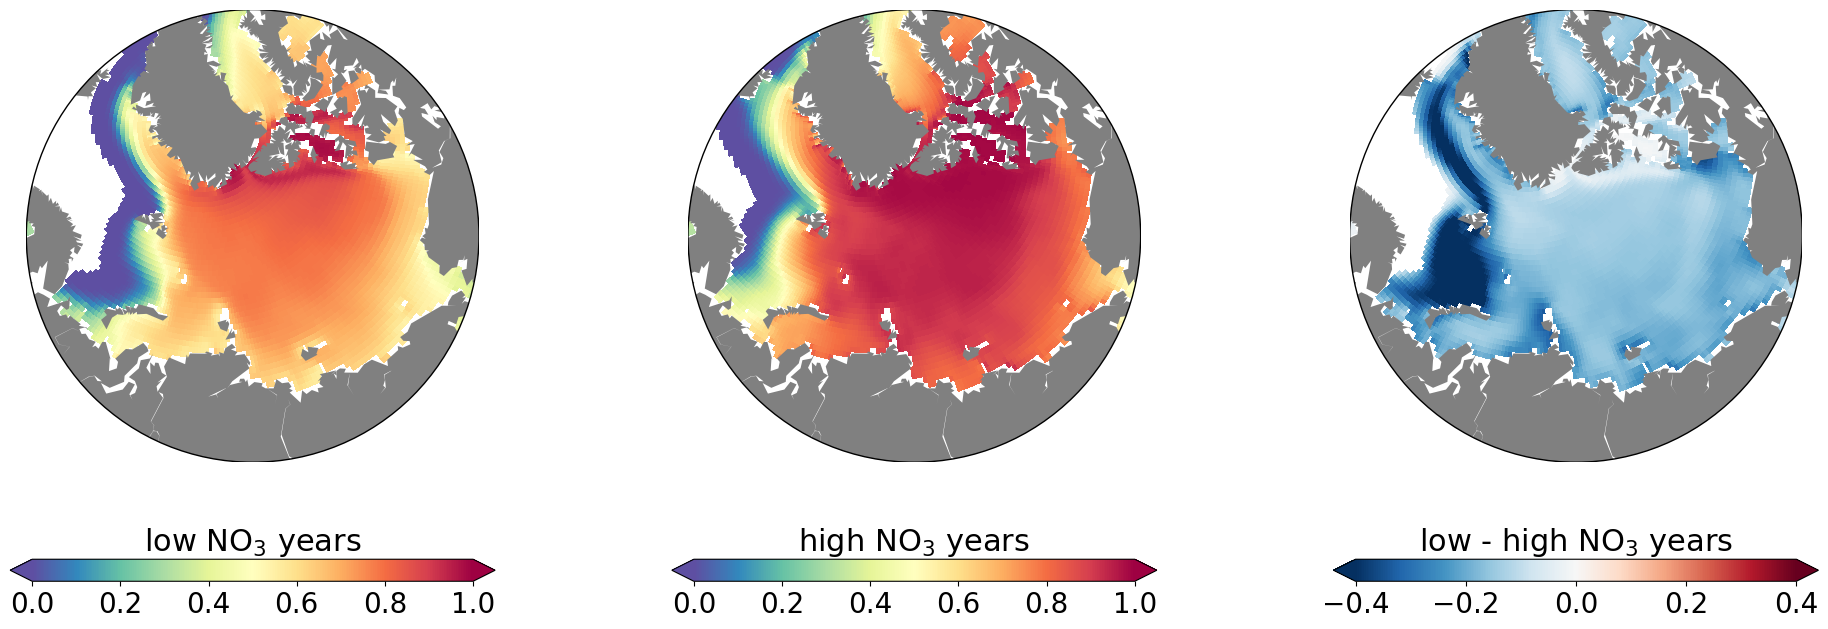

In [18]:
fig = plt.figure(figsize=(20, 20))

# High NO3 
ax = fig.add_subplot(3, 3, 1)
lon, lat, low = adjust_pop_grid(ds_01_avg.TLONG, ds_01_avg.TLAT, np.nanmean(low_ice_years_temp,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, low, cmap='Spectral_r', vmin = 0, vmax = 1);
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('low NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

# Low NO3 
ax = fig.add_subplot(3, 3, 2)
lon, lat, high = adjust_pop_grid(ds_01_avg.TLONG, ds_01_avg.TLAT, np.nanmean(high_ice_years_temp,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, high, cmap='Spectral_r', vmin = 0, vmax = 1);
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

# High - Low NO3  
ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, low-high, cmap='RdBu_r', vmin = -0.4, vmax = 0.4);
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('low - high NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)
plt.tight_layout()